# Facebook: Paid vs Unpaid Posts

Moro et al., 2016### Introduction:
**Background:** 

We are in the digital era, and Facebook is one of the biggest social media platforms known to society. Hence, it is a great place for businesses to reach consumers globally. With this idea in mind, we believe it would be beneficial for businesses to know if they should pay for a post to achieve a certain number of post total reach, post engagements, and page likes, or if it is better to follow the organic route. This is significant for designing marketing strategies, especially for small businesses or start-ups with small funds. We chose two different metrics for Facebook posts that we thought would have the highest influence on the success of advertising, lifetime post total reach and lifetime people who have liked the page and engaged with the post, to make a prediction on whether the post was paid or unpaid.

**Question:** 

Can we use the amount of lifetime post total reach and lifetime people who have liked the page and engaged with the post to predict whether a future post is paid or unpaid?

**Dataset:** 

The dataset we have is from 790 Facebook posts of a renowned cosmetic brand in 2014, and it shows the type of post (paid vs unpaid) as well as information on it, from the number of likes and shares to total impressions. According to the paper from which the dataset is based on, "Most of the information was exported directly from the company's Facebook page", and this includes "paid", "lifetime post total reach", and "lifetime people who have liked the page and engaged with the post", the columns that we are interested in. The link to the dataset is: https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip (Moro et al., 2016)

**Predictor variable description:** 

"Lifetime post total reach" is a chosen predictor because it is a measure of how much exposure a post achieves by the quantifying the number of unique users who have seen the post in their screen. In this scenario, "unique users" mean that an individual who owns multiple accounts is only considered as one user. 

On the other hand, "lifetime people who have liked the page and engaged with the post" is the number of unique users who have liked the page and clicked anywhere in a page's post. "Engagements" pertain to all the types and origins of clicks on the specific post. This predictor is chosen as it is said to be a stronger measure for user feedback, since this would ensure that the user is interested in the post. Therefore, we use these two predictors to determine if the post was organic or not because we believe companies would want to know whether their post is both seen and engaged with. (Moro et al., 2016)

### Methods and Results:

##### Step 1
The following packages are loaded using the library function to be able to use the functions necessary to build, tune, and estimate the accuracy of the classifier.

In [26]:
library(tidyverse)
library(repr)
library(tidymodels)

##### Step 2
The dataset is downloaded from the UCI Machine Learning Repository. In this project, we will be using the 2014 Facebook page of a renowned cosmetic brand. The as_factor() function is used to convert the Paid column into a factor instead of an integer because it is the column we are going to be predicting. With this, it can now be used as a class/label that observations can be categorized into. Moreover, the select() function is used to select the columns, Lifetime Post Total Reach, and Lifetime People who have liked your Page and engaged with your post, as the chosen predictors for our classifier. Furthermore, in this dataset, 0 = unpaid and 1 = paid. 

In [27]:
set.seed(3060)
options(repr.plot.width = 8, repr.plot.height = 8)
options(repr.matrix.max.rows = 6)
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip",temp, mode="wb")
unzip(temp, "dataset_Facebook.csv")
facebook_unscaled <- select(mutate(read.delim('dataset_Facebook.csv', sep=';'), Paid=as_factor(Paid)), Paid, Lifetime_Post = Lifetime.Post.Total.Reach, Lifetime_Like_Engage = Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post)

#scale the variables
facebook <- facebook_unscaled %>%
    filter(!is.na(Paid)) %>%
    mutate(Lifetime_Post = scale(Lifetime_Post, center = TRUE), Lifetime_Like_Engage = scale(Lifetime_Like_Engage, center = TRUE))
facebook

Paid,Lifetime_Post,Lifetime_Like_Engage
<fct>,"<dbl[,1]>","<dbl[,1]>"
0,-0.4908219,-0.8016572
0,-0.1521492,0.8111968
0,-0.5057168,-0.7804569
⋮,⋮,⋮
0,-0.4588352,-0.5048529
0,-0.4457417,-0.4037438
0,-0.4291332,-0.3923282


**Table 1: Scaled Facebook Dataset**

##### Step 3
The dataset is then randomly shuffled and split into a training and testing set, wherein the training set consists of 75% of the dataset whereas the testing set consists of the remaining 25%. The training set is used to build and tune the classifier. The testing set is used to estimate the accuracy of the training set classifier in predicting observations in the testing set. This is where we also tell the classifier that the class we want to predict is the Paid column. We also visualize a plot using the training data with Lifetime Post Total Reach on the x-axis and Lifetime People who have liked your Page and engaged with your post on the y-axis, with Paid/Unpaid being distinguished by colors. We couldn't find a trend and also was impossible differentiate paid/unpaid purely based on the graph.

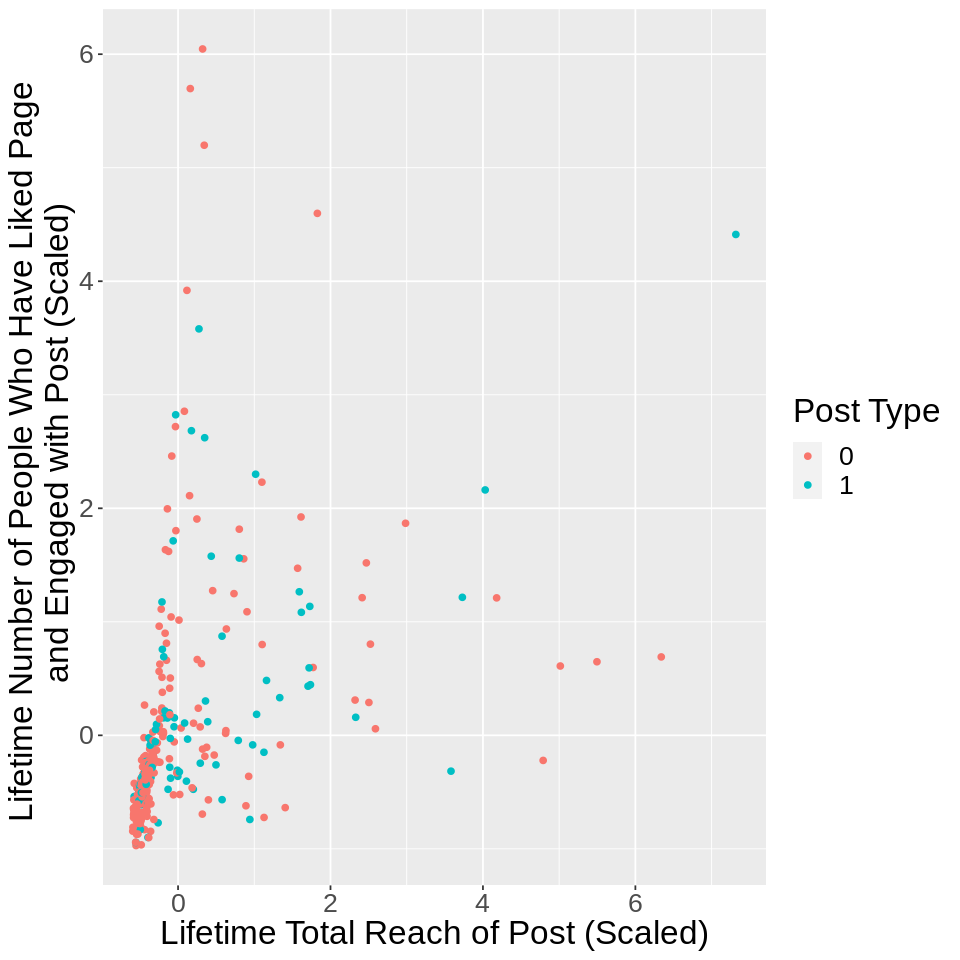

In [42]:
#splitting the data into a training and testing dataset
facebook_split <- initial_split(facebook, prop = 0.75, strata = Paid) 
facebook_train <- training(facebook_split)   
facebook_test <- testing(facebook_split)

facebook_plot <- ggplot(facebook_train, aes(x = Lifetime_Post, y = Lifetime_Like_Engage, colour = Paid)) +
    geom_point() +
    labs(x = "Lifetime Total Reach of Post (Scaled)", y = "Lifetime Number of People Who Have Liked Page \n and Engaged with Post (Scaled)",
              color = "Post Type") +
    theme(text = element_text(size = 20))
facebook_plot

**Graph 2: Lifetime Post Total Reach vs Lifetime People who have Liked the page and Engaged with the post**

##### Step 4
Using the training dataset, we build and tune the classifier that we will use to predict observations. It is important that we scale and center the chosen predictors, using the setp_scale() and step_center() functions, to ensure that no variable would have a higher influence in the prediction due to their larger scale. We include in our recipe that the predictors we want are Lifetime_Post and Liketime_Like_Engage, therefore using all_predictors() would mean that these are the variables we would like to scale and center. Furthermore, we do 5-fold cross-validation, using the vfold_cv() function, to build the model to establish the number of neighbours that would be best to achieve the highest estimated accuracy. We then add the recipe and model into our workflow wherein we tell the classifier we want to try tuning it with 10 different Ks through the grid argument.

In [20]:
#building and tuning the classifier
facebook_recipe <- recipe(Paid ~ Lifetime_Post + Lifetime_Like_Engage, data = facebook_train) %>%
   step_scale(all_predictors()) %>%
   step_center(all_predictors())

facebook_vfold <- vfold_cv(facebook_train, v = 5, strata = Paid)

knn_tune<- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
      set_engine('kknn') %>%
      set_mode('classification')

knn_results <- workflow() %>%
      add_recipe(facebook_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = facebook_vfold, grid = 10) %>%
      collect_metrics()

##### Step 5
Because we only care about the mean of the accuracy, we use the filter() function to filter out these specific rows under the .metric column. We then plot out the graph wherein the x-axis consists of the neighbors column and the y-axis contains the respective means of these neighbours. The graph allows us to visualize and choose the k with the highest accuracy to use for our testing dataset.

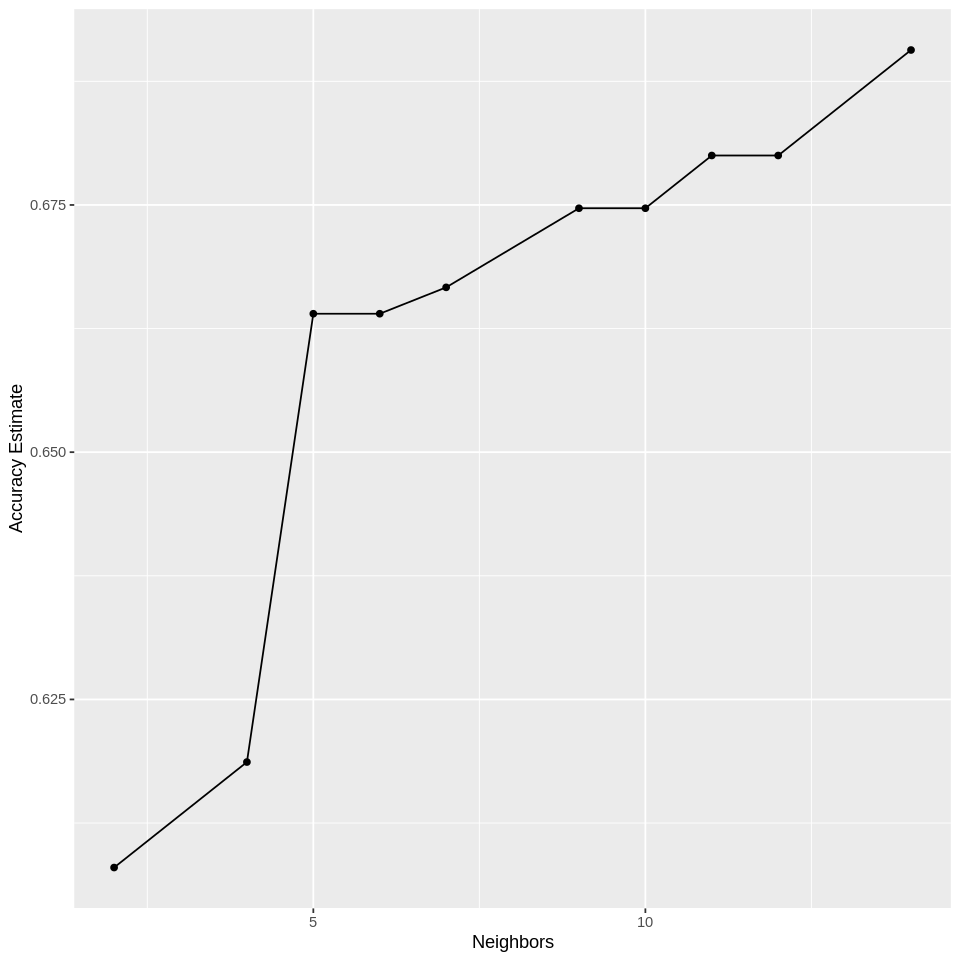

In [5]:
#choosing the correct number of neighbours
accuracies <- knn_results %>% 
      filter(.metric == 'accuracy')

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate")

accuracy_versus_k

**Graph 2: K value vs Accuracy Graph**

##### Step 6
Through the graph, we see that the number of neighbours with the highest accuracy estimate of around 70% is 14. However, we cannot be absolutely sure based on visualization, so we use the filter() function to filter out the row with the highest mean and pull(neighbors) function to pull the value of the k with the highest accuracy, which indeed turned out to be 14.

In [6]:
#building classifier with chosen number of neighbours
k_max <- accuracies %>%
    filter(mean == max(mean)) %>%
    pull(neighbors)
k_max

knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = k_max) %>%
      set_engine('kknn') %>%
      set_mode('classification')

[1] 14

##### Step 7
Next, we perform the workflow analysis again. We run cross-validation on each train/validation split to determine how accurate was the classifier's validation across the folds. The collect_metrics functions shows a table with the mean accuracy and standard error (uncertainty of mean value).

In [7]:
facebook_fit <- workflow() %>%
      add_recipe(facebook_recipe) %>%
      add_model(knn_spec) %>%
      fit_resamples(resamples = facebook_vfold)

facebook_metrics<-collect_metrics(facebook_fit)
facebook_metrics

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,binary,0.6906667,5,0.01292715
roc_auc,binary,0.5652557,5,0.02241967


**Table 2: Classifier's Prediction Accuracy on the Training Dataset**

##### Step 8
Now that we have created our K-nearest neighbor classifier object with max k accuracy (k=14), we need to test our tuned classifier on the testing data next. First, we train the classifier with the training data set using the workflow function. This bundles together your pre-processing, modeling, and post-processing requests. Then we use the classifier to predict the Paid value using the two predictors in the testing dataset. Lastly, we compare the classifier predictions to the true values from the Paid column in the testing dataset to measure the accuracy. We displayed this using a metrics table and also a confusion matrix for better visualization

In [22]:
#estimating the accuracy of the classifier on the testing data
facebook_fit_test <- workflow() %>%
    add_recipe(facebook_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = facebook_train)

facebook_test_prediction <- predict(facebook_fit_test, facebook_test) %>%
    bind_cols(facebook_test)

facebook_metrics <- facebook_test_prediction %>%
    metrics(truth = Paid, estimate = .pred_class)
facebook_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.70161290
kap,binary,0.07200647


**Table 3: Classifier's Prediction Accuracy on the Testing Dataset**

In [21]:
confusion <- facebook_test_prediction %>%
    conf_mat(truth = Paid, estimate = .pred_class)
confusion

          Truth
Prediction  0  1
         0 82 29
         1  8  5

**Table 4: Confusion Matrix**

### Discussion:

Overall, it was found that Lifetime Post reach and Lifetime Likes and Engagement are moderately accurate predictors of whether a Facebook post is paid or not. Although the classifiers have a combined accuracy of around 69% on the training dataset (Table 2), and 70% on the testing dataset (Table 3), the predicted trend is not reliably seen in our results. We see in Graph 2, that there is a positive relationship between the two variables, however, it is still difficult to determine the type of post using only the graph. Finally, in Table 4, we see on the confusion matrix that despite 87 observations are predicted correctly, 37 predictions are incorrect. It can also be noted that we predicted 29 unpaid posts when they were actually paid posts, and only 5 were correctly predicted. This means that the classifier's accuracy is fairly skewed and unreliable since the ratio of correct predictions are 82:5 for unpaid to paid posts. Therefore, the classifier is unreliable in predicting paid posts. Tracing back, perhaps the k-value for the classifier also suffers from the same problem. The k value of 14 had the highest accuracy, but that could also be skewed by identifying a higher number of unpaid posts correctly, which could be a question for further analysis.

Contrary to our hypothesis, a higher lifetime post count and higher lifetime likes + engagement did not reliably correlate to a paid post. This finding seemingly replicates the findings of another study 
(Moro et al., 2016), where it was found that a paid post only boosts its reachability by 7%. Interestingly, lifetime post reach is a slightly more accurate predictor, compared to the other variable we tested. 

Another study by (Quesenberry & Coolsen, 2018) found that many different factors may affect post likes and engagement. For example, post content and even when the post was created have significant effects on how many likes/engagements the post achieves. Thus, these other factors should be examined in future studies to determine how they may act as moderating factors. In terms of application, companies can use this information, combined with actual purchasing data, to streamline their advertising strategies. Specifically, paying for a specific type of post in a specific month may help increase post reach, which would increase potential consumer exposure, which may in turn increase purchases. 

Based on the accuracy of our classifier, we think that there is room for improvement before we can make any recommendations regarding whether the post should be paid or not. For instance, perhaps looking at more predictors is better as there were paid posts with low reach, low engagement, and low page likes, hence there must be another factor involved in determining the type of post. Another improvement is to include more paid posts in our data because they were the observations that were mispredicted the most (Table 4). Perhaps we should tune the classifier only on paid posts and see how that would change the accuracy.

Questions that can be asked are: Why do some paid posts have low total reach, low engagement, and low page likes? Is there other factor/s the companies are considering when paying for posts? Does having a higher reach and engagement even translate to having a better value from posts?

### Reference:

Moro, S., Rita, P., & Vala, B. (2016). Predicting social media performance metrics and evaluation of the impact on brand building: A data mining approach. Journal of Business Research, 69(9), 3341-3351. doi:10.1016/j.jbusres.2016.02.010


Quesenberry, K. A., & Coolsen, M. K. (2018). What Makes Facebook Brand Posts Engaging? A Content Analysis of Facebook Brand Post Text That Increases Shares, Likes, and Comments to Influence Organic Viral Reach. Journal of Current Issues & Research in Advertising, 40(3), 229-244. doi:10.1080/10641734.2018.1503113

